In [245]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, norm, gamma, invgamma

np.random.seed(42)

In [162]:
# MSE Calculation
def get_mse(estimates, true_value):
    N = len(estimates)
    mse = [(1/(idx+1)) * (est - true_value)**2 for idx, est in enumerate(estimates)]
    return mse

# Binomial Conjugate Estimator

In [77]:
def binomial_mle(data):
    return np.mean(data) / len(data)

# Beta Mean: alpha + num_successes / alpha + beta + total_trials

def binomial_conjugate(data, n, alpha, beta):
    num_successes = np.sum(data) 
    num_trials = n * len(data)
    return (alpha + num_successes) / (alpha + beta + num_trials)

#Update Equations and pdf plotting for the Binomial scenario 
def binomial_posterior_density(a0, b0, N, p):
    data = np.random.binomial(1, p, N)
    
    num_success = np.sum(data)

    #Update Equations
    aN = a0 + num_success
    bN = b0 + (N-num_success)

    x = np.linspace(0.01, 0.99, 10000)
    y = beta.pdf(x, aN, bN)
    plt.plot(x,y)
    ret = [aN, bN, data]
    return ret

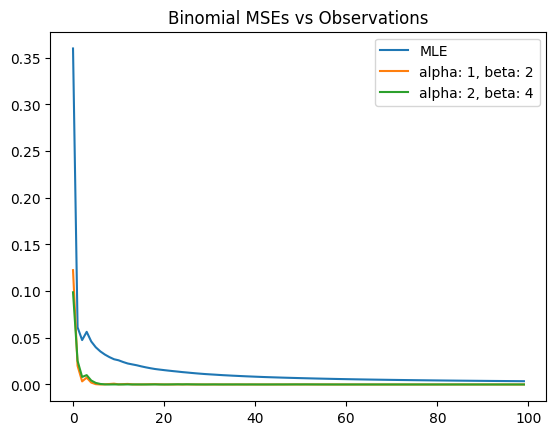

In [79]:
# Binomial params
n = 1
p = 0.6
bin_alphas = [1, 2]
bin_betas = [2, 4]

n_samples = 100

binomial_data = np.random.binomial(n, p, n_samples)

# MLE plots
binomial_mle_estimates = [binomial_mle(binomial_data[:i+1]) for i in range(n_samples)]
mle_mse = get_mse(binomial_mle_estimates, p)
plt.plot(mle_mse, label= 'MLE')

for bin_alpha, bin_beta in zip(bin_alphas, bin_betas):
    binomial_conjugate_estimates = [binomial_conjugate(binomial_data[:i+1], n, bin_alpha, bin_beta) for i in range(n_samples)]
    conj_mse = get_mse(binomial_conjugate_estimates, p)
    plt.plot(conj_mse, label=f'alpha: {bin_alpha}, beta: {bin_beta}')
    plt.title('Binomial MSEs vs Observations')
    plt.legend()


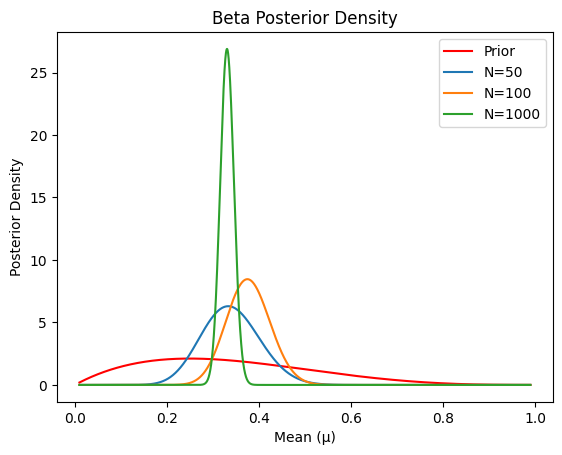

In [80]:
a0 = 2
b0 = 4
p = a0/(a0+b0)

# Posterior Density Plot
fig = plt.figure()
x = np.linspace(0.01,0.99,10000)
plt.plot(x, beta.pdf(x, a0, b0), 'r-')
plt.title('Beta Posterior Density')
plt.xlabel('Mean (µ)')
plt.ylabel('Posterior Density')

binomial_posterior_density(a0, b0, 50, p)
binomial_posterior_density(a0, b0, 100, p)
ret = binomial_posterior_density(a0, b0, 1000, p)

plt.legend(['Prior','N=50','N=100', 'N=1000'])


# Gaussian with Known Variance

In [101]:
def gaussian_known_variance_mle(data):
    return np.mean(data) / len(data)

# ref: https://youtu.be/R3pdTd2mVaI?si=CsBdZu7ni4ech2Gj&t=1612
def gaussian_known_variance_conjugate(data, mu_0, tau_0, sigma):
    n = len(data)
    x_bar = (1/n) * np.mean(data)
    # mu_n = (mu_0 * sigma**2 + tau_0**2 * np.sum(data)) / (tau_0**2 + n * sigma**2)
    mu_n = sigma**2 / (sigma**2 + n * tau_0**2) * mu_0 + n * tau_0**2 / (sigma**2 + n * tau_0**2) * x_bar
    return mu_n

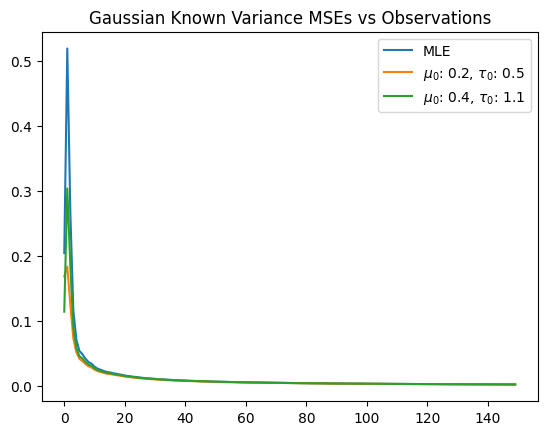

In [127]:
# Gaussian pt 1 params + mse plots
mu_true = 0.6
sigma_true = 1.0

mu_0s = [0.2, 0.4]
tau_0s = [0.5, 1.1]

n_samples = 150

gaussian_data = np.random.normal(mu_true, sigma_true, n_samples)

gaussian_known_var_mle_estimates = [gaussian_known_variance_mle(gaussian_data[:i+1]) for i in range(n_samples)]
mle_mse = get_mse(gaussian_known_var_mle_estimates, mu_true)
plt.plot(mle_mse, label= 'MLE')

for mu_0, tau_0 in zip(mu_0s, tau_0s):
    gaussian_known_var_conjugate_estimates = [gaussian_known_variance_conjugate(gaussian_data[:i+1], mu_0, tau_0, sigma_true) for i in range(n_samples)]
    conj_mse = get_mse(gaussian_known_var_conjugate_estimates, mu_true)
    plt.plot(conj_mse, label=f'$\\mu_0$: {mu_0}, $\\tau_0$: {tau_0}')
    plt.title('Gaussian Known Variance MSEs vs Observations')
    plt.legend()

In [134]:
def gauss_known_var_posterior_density(sig, tau0, mu0, N):   
    var = sig**2
    var0 = tau0**2
    
    x = np.linspace(0.01, 0.99, N)
    data = np.random.normal(mu0, sig, N)
    
    mu_mle = np.sum(data)/N
    
    #Update Equations
    muN = var/(N*var0 + var)*mu0 + (N*var0)/(N*var0 + var)*mu_mle
    varN = 1/((1/var0) + (N/var))    

    y = norm.pdf(x, muN, varN)

    plt.plot(y)

    return data


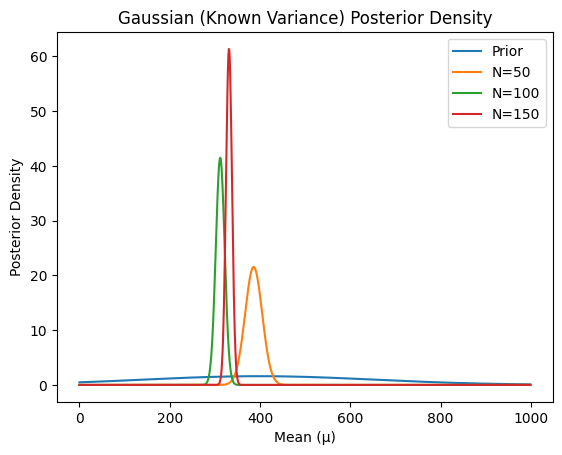

In [139]:
# Gaussian with known Variance -> find Mean
#Gamma Distribution Parameters
mu0 = 0.4
sig = 1         #this is regular sigma
sig0 = 0.5

x = np.linspace(0.01, 0.99, 1000)
y = norm.pdf(x, mu0, sig0**2)

plt.plot(y)
plt.title('Gaussian (Known Variance) Posterior Density')
plt.xlabel('Mean (µ)')
plt.ylabel('Posterior Density')

# updated plot - N trials
gauss_known_var_posterior_density(sig, sig0, mu0, 50)

# second update
gauss_known_var_posterior_density(sig, sig0, mu0, 100)

# third update
data = gauss_known_var_posterior_density(sig, sig0, mu0, 150)
plt.legend(['Prior', 'N=50', 'N=100', 'N=150'])


# Gaussian with Known Mean

In [214]:
# Gaussian Distribution with Known Mean -> Conj. Prior: Inv Gamma
def gaussian_known_mean_mle(data, mu, alpha, beta):
    n = len(data)
    sum_squared_diff = 0
    for d in data:
        sum_squared_diff += np.sum((d - mu)**2)
    bN = beta + sum_squared_diff / 2
    return (bN - beta) * (2/n)

def get_true(data, mu):
    n = len(data)
    sum_squared_diff = 0
    for d in data:
        sum_squared_diff += np.sum((d - mu)**2)
    return sum_squared_diff / n

# ref: https://youtu.be/C_ZszihZzV0?si=WpElMVrvH7HaAbOu&t=1104
def gaussian_known_mean_conjugate(data, mu, alpha, beta):
    n = len(data)
    sum_squared_diff = 0
    for d in data:
        sum_squared_diff += np.sum((d - mu)**2)
    beta_n = beta + sum_squared_diff / 2
    alpha_n = alpha + n / 2
    return alpha_n / beta_n


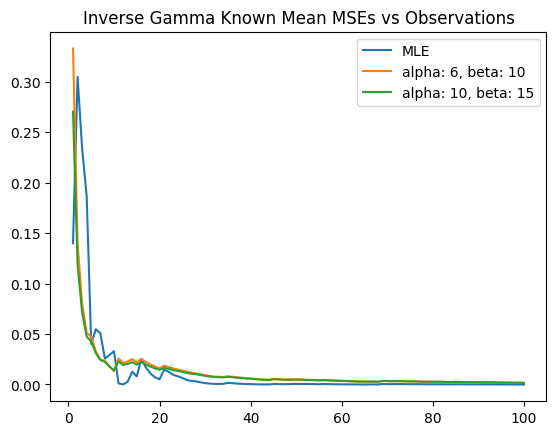

In [233]:
# Gaussian + Known Mean

gauss_alphas = [6, 10]
gauss_betas = [10, 15]

mu_true = gauss_alphas[0] / gauss_betas[0]
n_samples = 100

x = np.linspace(1, n_samples, n_samples)
gaussian_data = np.random.normal(mu_true, 1, n_samples)
mse_mu = get_true(gaussian_data, mu_true)

# MLE plots
gaussian_known_mean_mle_estimates = [gaussian_known_mean_mle(gaussian_data[:i+1], mu_true, gauss_alphas[0], gauss_betas[0]) for i in range(n_samples)]
mle_mse = get_mse(gaussian_known_mean_mle_estimates, mse_mu)
plt.plot(x, mle_mse, label= 'MLE')


for g_alpha, g_beta in zip(gauss_alphas, gauss_betas):
    # x = np.linspace(0, n_samples-1, n_samples)
    gaussian_conjugate_estimates = [gaussian_known_mean_conjugate(gaussian_data[:i+1], mu_true, g_alpha, g_beta) for i in range(n_samples)]
    conj_mse = get_mse(gaussian_conjugate_estimates, mse_mu)
    plt.plot(x, conj_mse, label=f'alpha: {g_alpha}, beta: {g_beta}')
    plt.title('Inverse Gamma Known Mean MSEs vs Observations')
    plt.legend()


In [291]:
def gauss_known_mean_posterior_density(mu, a0, b0, N):
    data = np.random.normal(mu, 1, N)
    x = np.linspace(0.01, 2.5, N)
    total = 0

    aN = a0 + N / 2
    for i in data:
        total += (i - mu) ** 2
    bN = b0 + 0.5 * total

    y = invgamma.pdf(x, aN, scale=bN)
    plt.plot(x, y)


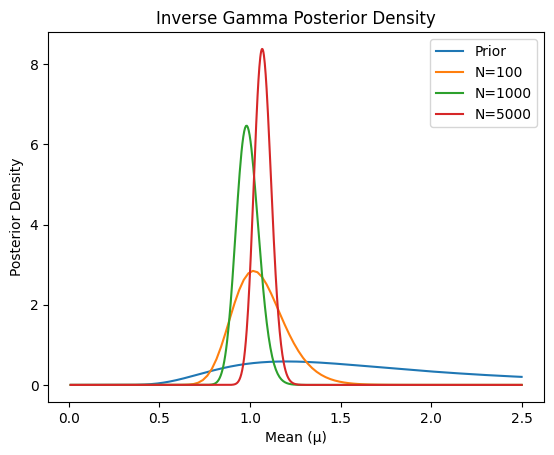

In [292]:
a0 = 4.0
b0 = 6.0
mu = a0/b0

plt.figure()

x = np.linspace(0.01, 2.5, 1000)
y = invgamma.pdf(x, a0, scale=b0)
plt.plot(x, y)

gauss_known_mean_posterior_density(mu, a0, b0, 100)
gauss_known_mean_posterior_density(mu, a0, b0, 500)
gauss_known_mean_posterior_density(mu, a0, b0, 1000)

plt.title('Inverse Gamma Posterior Density')
plt.xlabel('Mean (µ)')
plt.ylabel('Posterior Density')
plt.legend(['Prior', 'N=100', 'N=1000', 'N=5000'])
